# Text classification

Finally we will look at an example of classification on unstructured data. The dataset we use is the BBC News Classification dataset from Kaggle https://www.kaggle.com/bbose71/bbc-news-classification.

To classify text, it is common to transform the text into vector representation. In a simple bag-of-word vector representation, every word in the collection is a feature and in each documents we simply count how often each word appears. So if our dictionary consists of [ i, am, hungy, and, thirsty ], then the text "I am hungry" would become (1, 1, 1, 0, 0), the text "I am thirsty" (1, 1, 0, 0, 1) and the text "I am hungry and I am thirsty" (2, 2, 1, 1, 1). Since these now are numbers, we can train a classifier like before.

# Text parsing

Several decisions affect the vectorization of text. Commonly, sentences are split on whitespace and punctuation marks to get words. Words are often lowercased and brought back to their stem (i.e. walk, walked, walking are all converted to their stem 'walk') and a list of relatively meaningless words, the so called 'stopwords', are removed.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score

In [2]:
df = pd.read_csv("All-seasons.csv")

In [3]:
df = df[df['Character'].isin(['Stan', 'Kyle', 'Randy', 'Butters', 'Cartman'])]

The collection contains labels for the categories. We can use the `factorize` method to extract the unique values and assign these to unique numbers starting from 0. 

In [4]:
df['Character_id'] = df.Character.factorize()[0]

In [5]:
df.groupby('Character').Character_id.count()

Character
Butters    2602
Cartman    9774
Kyle       7099
Randy      2467
Stan       7680
Name: Character_id, dtype: int64

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, encoding='latin-1', stop_words='english')

In [7]:
features = vectorizer.fit_transform(df.Line[:1500]).toarray()

In [8]:
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

By looking at the shape, we see there are 2225 documents in the collection and 14415 words.

In [9]:
features.shape

(1500, 304)

Train the models using n-fold cross validation, and take the average accuracy over the experiments. We see an accuracy above 97.7%.

In [10]:
model = LogisticRegression()
model.fit(features, df.Character.to_numpy()[:1500])
pred_y = model.predict(features)
accuracy_score(df.Character.to_numpy()[:1500], pred_y)

0.6346666666666667

In [11]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [12]:
acc = []
y = df.Character.to_numpy()[:1000]
for x in range(2,20):
    kf = KFold(n_splits=x,random_state=42,shuffle=True)
    acc_nested = []
    for train, valid in kf.split(y):
        train_X = features[train]
        valid_X = features[valid]
        train_y = y[train]
        valid_y = y[valid]    
        
        model = LogisticRegression(solver='liblinear', multi_class='auto')
        model.fit(train_X, train_y)
        pred_y = model.predict(valid_X)
        

        
        
        acc_nested.append(accuracy_score(valid_y, pred_y))
        
        
    acc_nested_avg = sum(acc_nested)/len(acc_nested)
    acc.append(acc_nested_avg)
    
    
acc



[0.425,
 0.4459699220178262,
 0.44899999999999995,
 0.45899999999999996,
 0.4490056032513286,
 0.4460398756173404,
 0.45199999999999996,
 0.44798369798369797,
 0.442,
 0.45405705405705404,
 0.4479226429527634,
 0.44806509280193496,
 0.4369271182651464,
 0.4399668325041458,
 0.43583589349718366,
 0.4449926083817513,
 0.4468975468975469,
 0.4379726529676877]

In [13]:
var1x = np.array(acc_nested)
var1y = np.array(pred_y)


#plt.scatter(var1x, var1y)
#plt.show()

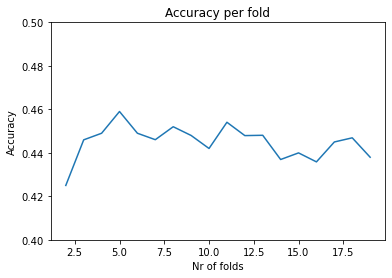

In [14]:
plt.plot(range(2,20),acc)
plt.ylim([0.4,0.5])
plt.ylabel('Accuracy')
plt.xlabel('Nr of folds')
plt.title('Accuracy per fold')
plt.show()

# Inverse Document Frequency

When we process texts, not all words are equally meaningful. For instance the literal 'the', and 'a' do not add much meaning to the representation of what a text is about. Karen Spark-Jones noticed that the meaningfulness of a word in a collection depends on how discriminating that word is. This can be estimated by looking at the number of documents a word appears in. In English collections, literals appear in virtually all documents indicating that they are meaningless. But words such as fight, angry, mathematics appear in only a fraction. According to her theory we can express the meaningfulness as the inverse document frequency in a collection $\text{idf_t} = log \frac{N}{n_t}$, where $t$ is a word that appears in a collection of documents, $N$ is the number of documents in the collection and $n_t$ is the number of documents the term $t$ appears in.

We can use the Inverse Document Frequency (IDF) to weight the terms accoriding to their importance, which is also known as TF-IDF.

# N-Grams

Another way to vectorize text is to not just consider single words but to also extract 2-word combinations, also referred to as bi-grams of 2-n-grams. The Vectorizers in SKLearn support automatic n-gram extraction by supplying a parameter. `ngram_range=(1,2)` means that unigrams (single words) and bigrams are both used.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [16]:
features = tfidf.fit_transform(df.text).toarray()

AttributeError: 'DataFrame' object has no attribute 'text'

In [ ]:
features

By rerunning the experiment with TFIDF we see that accuracy improves to 98.2%

In [ ]:
kf = KFold(n_splits=10, random_state=0, shuffle=True)
y = df.category_id.to_numpy()
acc = []
for train, valid in kf.split(y):
    train_X = features[train]
    valid_X = features[valid]
    train_y = y[train]
    valid_y = y[valid]
    
    model = LogisticRegression(solver='liblinear', multi_class='auto')
    model.fit(train_X, train_y)
    pred_y = model.predict(valid_X)
    acc.append(accuracy_score(valid_y, pred_y))
sum(acc)/len(acc)